In [1]:
from google.colab import drive
import os

#drive.mount("/content/drive")

#%cd /content/drive/MyDrive/EPITA/SCIA/ing3/DNN/

In [2]:
!pip install transformers

In [79]:
from model import BertForTokenAndSequenceJointClassification

import torch
import torch.onnx
import tensorflow as tf

from transformers import BertTokenizerFast
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# PropagandaTechniquesAnalysis-en-BERT Model

### Tests on the model

In [30]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [31]:
model = BertForTokenAndSequenceJointClassification.from_pretrained(
    "QCRI/PropagandaTechniquesAnalysis-en-BERT",
    revision="v0.1.0",
).to(device)

In [36]:
def classify_text(text: str):
    inputs = tokenizer.encode_plus(text, return_tensors="pt").to(device)
    outputs = model(**inputs)

    token_class_index = torch.argmax(outputs.token_logits, dim=-1)
    tags = [model.token_tags[i] for i in token_class_index[0].tolist()[1:-1]]

    sequence_class_index = torch.argmax(outputs.sequence_logits, dim=-1)
    sequence_class = model.sequence_tags[sequence_class_index[0]]
    return sequence_class

In [42]:
classify_text('A close-up of a sign advertising a Front National  restaurant')

'Non-prop'

In [20]:
PROMPT = "a close up of a sign advertising a front national restaurant"
inputs = tokenizer.encode_plus(PROMPT, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101,  170, 1601, 1146, 1104,  170, 2951, 6437,  170, 1524, 1569, 4382,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [21]:
outputs = model(**inputs)
#outputs

In [22]:
sequence_class_index = torch.argmax(outputs.sequence_logits, dim=-1)
sequence_class_index

tensor([0])

In [23]:
sequence_class = model.sequence_tags[sequence_class_index[0]]
sequence_class

'Non-prop'

In [24]:
token_class_index = torch.argmax(outputs.token_logits, dim=-1)
token_class_index

tensor([[7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [26]:
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0][1:-1])
#tokens

In [27]:
tags = [model.token_tags[i] for i in token_class_index[0].tolist()[1:-1]]
tags

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

### Adapt the model on the provided dataset

#### To prepare the data

In [ ]:
# ONLY IF WE WANT TO MODIFY CURRENT DATA
df1 = pd.read_csv('img2text_propaganda.csv')
df2 = pd.read_csv('img2text_movie_propaganda.csv')

# Concatenate the DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_csv_path = 'img2text_compare.csv'
merged_df.to_csv(merged_csv_path, index=False)

print(f"The two CSV files have been merged into {merged_csv_path}")

The two CSV files have been merged into img2text_compare.csv


In [6]:
df = pd.read_csv('img2text_compare (2).csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,classes,generated_text_1,generated_text_2
0,24968.jpg,none_propaganda,a photography of a poster for charlie chan london,a poster for charlie chan london starring in t...
1,image_389.png,propaganda,a photography of a poster advertising a politi...,a black and white poster with a black border a...
2,image_196.png,propaganda,a photography of a poster advertising a concer...,a poster advertising a concert at the grand ball
3,9893.jpg,none_propaganda,a photography of a woman in a dress and hat wi...,a poster for a concert with a woman in a dress...
4,image_357.png,propaganda,a photography of a poster advertising a french...,a poster advertising the birth of the french r...


#### Classify the text

In [6]:
def classify_text_(text: str, model, tokenizer, device):
    inputs = tokenizer.encode_plus(text, return_tensors="pt").to(device)
    outputs = model(**inputs)

    token_class_index = torch.argmax(outputs.token_logits, dim=-1)
    tags = [model.token_tags[i] for i in token_class_index[0].tolist()[1:-1]]

    sequence_class_index = torch.argmax(outputs.sequence_logits, dim=-1)
    sequence_class = model.sequence_tags[sequence_class_index[0]]
    return sequence_class

In [9]:
def predict_best_classes(df, model, tokenizer, device):
    # Select the relevant columns
    texts = df['generated_text_2'].tolist()
    true_labels = df['classes'].tolist()

    # Create an empty list to store predicted labels
    predicted_labels = []

    # Initialize variables for accuracy calculation
    correct_predictions = 0
    correct_predictions_prop = 0
    total_samples = len(texts)

    # Evaluate each text and store the predicted label
    for text, true_label in zip(texts, true_labels):
      predicted_label = classify_text_(text, model, tokenizer, device)
      if predicted_label == 'Prop':
        predicted_label = 'propaganda'
        if predicted_label == true_label:
          correct_predictions_prop += 1
        print(f"text is: {text}")# and true_label is : {true_label} and predicted is: {predicted_label}")
      else:
        predicted_label = 'none_propaganda'
      predicted_labels.append(predicted_label)

      # Check accuracy
      if predicted_label == true_label:
        correct_predictions += 1
    # Calculate accuracy
    accuracy = (correct_predictions / total_samples) * 100

    # Add predicted labels to the DataFrame
    df['predicted_class'] = predicted_labels
    propaganda_count = df['predicted_class'].value_counts().get('propaganda', 0)
    accuracy_prop = (correct_predictions_prop / propaganda_count)* 100


    return accuracy, accuracy_prop

#### Prediction results

In [10]:
# Tokenize the texts
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

# Instantiate your BERT model
model = BertForTokenAndSequenceJointClassification.from_pretrained(
    "QCRI/PropagandaTechniquesAnalysis-en-BERT",
    revision="v0.1.0",
).to(device)

# Predict the best classes for each text and calculate accuracy
accuracy, accuracy_prop = predict_best_classes(df, model, tokenizer, device)

print(f'Accuracy: {accuracy:.2f}% and accuracy of propaganda prediction is: {accuracy_prop:.2f}%')

text is: a poster for the vampire bat starring two women and a man
text is: a poster for the man who knew too much
text is: a poster for the movie she done him wrong
text is: a poster for the film cinderella starring mary pickford and cinderella
text is: a poster for the movie harold lloyd and the cats paw
text is: a poster for the movie crazy lady
text is: a poster for the film the death kiss
text is: a poster for the old dark house
text is: a poster for the movie the mayor of hell
text is: a poster for the film hallein'in a rum
text is: a poster for the movie kentucky kernels
text is: a poster for the movie the art of the howling dog
text is: richard the knight - 11 x 17 movie poster - style a
text is: they fight for you protect them poster
text is: a picture of a poster for the movie arbuckle and keaton
text is: there is a poster of a flower with a halo on it
text is: the devil's brother - 11 x 17 movie poster - style a
text is: a picture of a movie poster for the movie sweet little

# Multinomial Naive Bayes classifier

In [41]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create TF-IDF vectors from the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['generated_text_1'])
X_test = vectorizer.transform(test_df['generated_text_1'])

# Map labels to numerical values
label_mapping = {'propaganda': 1, 'none_propaganda': 0}
y_train = train_df['classes'].map(label_mapping)
y_test = test_df['classes'].map(label_mapping)


In [42]:
len(test_df['generated_text_1'])

175

In [43]:
# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        67
           1       0.87      0.95      0.91       108

    accuracy                           0.88       175
   macro avg       0.89      0.86      0.87       175
weighted avg       0.88      0.88      0.88       175



# Pre-trained BERT model

In [126]:
def load_and_split_data(csv_path, test_size=0.2, random_state=42):
    df = pd.read_csv(csv_path)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    return train_df, test_df

def preprocess_data(train_df, test_df, tokenizer, generated_text, label_mapping):
    # Tokenize and encode the text data
    X_train = tokenizer(list(train_df[f'{generated_text}']), truncation=True, padding=True, return_tensors='pt', max_length=512)
    X_test = tokenizer(list(test_df[f'{generated_text}']), truncation=True, padding=True, return_tensors='pt', max_length=512)

    y_train = torch.tensor(train_df['classes'].map(label_mapping).values)
    y_test = torch.tensor(test_df['classes'].map(label_mapping).values)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
    test_dataset = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    return train_loader, test_loader

def train_model(model, train_loader, test_loader, optimizer, loss_fn, device, max_epochs=50, minim_epoch = 20, patience=5):
    train_losses = []
    accuracies = []
    best_accuracy = 0.0
    epochs_without_improvement = 0
    best_model = []

    model.to(device)
    for epoch in range(max_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate the model on the test set
        accuracy, avg_test_loss = evaluate_model(model, test_loader, device)
        accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}/{max_epochs} - Current accuracy:{accuracy:.4f}%")

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model.state_dict().copy()
            epochs_without_improvement = 0
        elif epoch >= minim_epoch:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience and epoch >= minim_epoch:
            print(f'Early stopping! No improvement for {patience} epochs.')
            break

    # Plot training history
    plot_training_history(train_losses, accuracies)

    return best_model, best_accuracy

def plot_training_history(train_losses, accuracies):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_losses, label='Train Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Test Accuracy', color=color)
    ax2.plot(accuracies, label='Test Accuracy', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_preds

def predict_text(text, model, tokenizer, device):
    # Tokenize and encode the input text
    input_ids = tokenizer.encode(text, return_tensors='pt', max_length=512)
    input_ids = input_ids.to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    # Map numerical prediction to label
    label_mapping_reverse = {1: 'propaganda', 0: 'none_propaganda'}
    predicted_label = label_mapping_reverse[prediction]

    return predicted_label


In [54]:
### Load pre-trained BERT model and tokenizer ###
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
### handle the data ###
train_df, test_df = load_and_split_data('img2text_compare (2).csv')

# Map labels to numerical values
label_mapping = {'propaganda': 1, 'none_propaganda': 0}

# Create DataLoader for training and testing sets
train_loader, test_loader = preprocess_data(train_df, test_df, tokenizer, 'generated_text_1', label_mapping)

Epoch 1/50 - Current accuracy:0.9143%
Epoch 2/50 - Current accuracy:0.9143%
Epoch 3/50 - Current accuracy:0.9200%
Epoch 4/50 - Current accuracy:0.9200%
Epoch 5/50 - Current accuracy:0.9143%
Epoch 6/50 - Current accuracy:0.9086%
Epoch 7/50 - Current accuracy:0.9086%
Epoch 8/50 - Current accuracy:0.8971%
Epoch 9/50 - Current accuracy:0.9086%
Epoch 10/50 - Current accuracy:0.9314%
Epoch 11/50 - Current accuracy:0.8914%
Epoch 12/50 - Current accuracy:0.9143%
Epoch 13/50 - Current accuracy:0.9086%
Epoch 14/50 - Current accuracy:0.9029%
Epoch 15/50 - Current accuracy:0.9029%
Epoch 16/50 - Current accuracy:0.9143%
Epoch 17/50 - Current accuracy:0.9143%
Epoch 18/50 - Current accuracy:0.8971%
Epoch 19/50 - Current accuracy:0.9200%
Epoch 20/50 - Current accuracy:0.9086%
Epoch 21/50 - Current accuracy:0.8914%
Epoch 22/50 - Current accuracy:0.8971%
Epoch 23/50 - Current accuracy:0.9029%
Epoch 24/50 - Current accuracy:0.9029%
Epoch 25/50 - Current accuracy:0.9086%
Early stopping! No improvement for

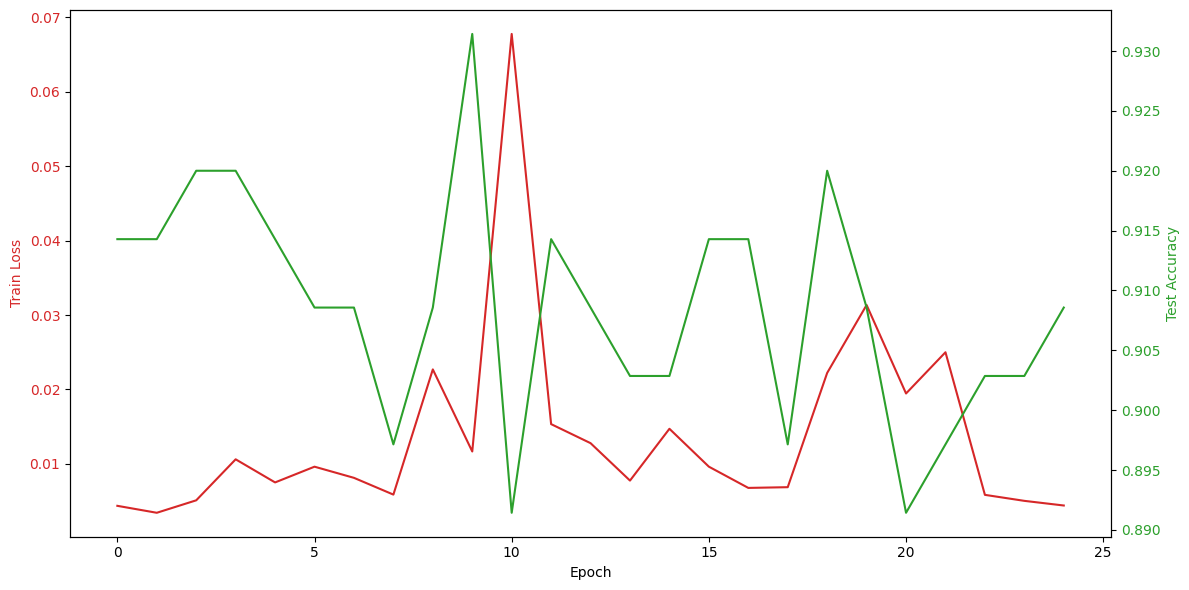

In [131]:
### Train the model ###
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
best_model_state_dict, best_accuracy = train_model(model, train_loader, test_loader, optimizer, loss_fn, device)

In [132]:
print(best_accuracy)

0.9314285714285714


In [139]:
# Load the best model
best_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
best_model.load_state_dict(best_model_state_dict)
best_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [140]:
### Evaluate the model and display the Calculated accuracy ###
accuracy, all_preds= evaluate_model(model, test_loader, device)
print(f'Best Model Test Accuracy: {accuracy:.4f}%')
print(classification_report(test_df['classes'].map(label_mapping).values, all_preds))

Best Model Test Accuracy: 0.9086%
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        67
           1       0.90      0.96      0.93       108

    accuracy                           0.91       175
   macro avg       0.91      0.89      0.90       175
weighted avg       0.91      0.91      0.91       175



In [88]:
### Predict on a given text ###
text_to_predict = "a photography of a sign advertising a front national restaurant"
predicted_label = predict_text(text_to_predict, best_model, tokenizer, device)
print(f'Predicted label for "{text_to_predict}": {predicted_label}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted label for "a photography of a sign advertising a front national restaurant": propaganda


In [95]:
best_model.eval()  # Set the model to evaluation mode

# Specify the directory path to save the model
saved_model_dir = "/content/saved_model_directory"

# Save the model to the specified directory
best_model.save_pretrained(saved_model_dir)